In [29]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import scipy
import json
import os
import import_ipynb

In [154]:
path = r'use_templates\sim_to_llm_template.json'

In [150]:
def json_exporter(path, t, N_rabbits, N_wolves, N_grass, pop_data, g_params):
    
    with open(path, 'r') as file:
        report_template = json.load(file)

    error = str()
    if N_rabbits == 0:
        error = 'All rabbits have died'
    if N_wolves == 0:
        error = 'All wolves have died'
    if N_grass == 0:
        error = 'All grass has died'
    if N_grass + N_rabbits + N_wolves > 10000:
        error = 'Total population has exceeded 10,000'

    report_data = {
        'Cause of instability': error,
        'node_population_sizes': {
            'N_rabbits': N_rabbits,
            'N_wolves': N_wolves,
            'N_grass': N_grass
        },
        'population_data_over_time': json.loads(pop_data.to_json(orient='index')),
        'simulation_parameters': g_params
    }

    if 'historic_data' in report_template and report_template['historic_data'] == '[data]':
        report_template['historic_data'] = report_data

    with open('report_template.json', 'w') as output_file:
        json.dump(report_template, output_file, indent=4)

In [ ]:
def theFlood(preFlood):
    path = 'model_outputs/model_outputs'
    with open(path, 'r') as file:
        postFlood = json.load(file)

    parameters = postFlood['parameters']
    populations = postFlood['populations']

    preFlood['t'] = preFlood['t'],
    preFlood['N_rabbits'] = populations['N_rabbits'],
    preFlood['N_wolves'] = populations['N_wolves'],
    preFlood['N_grass'] = populations['N_grass'],
    preFlood['g_params'] = parameters['g_params']

    return preFlood

In [151]:
#Define simulation parameters
g_params = {
    'alpha': 1,       #Eaten grass growth limit
    'beta': 1,        #Hunted rabbit growth limit
    'gamma' : 1,      #Rabbit breeding growth limit
    'delta' : 1,      #Wolf breeding growth limit
    'epsilon' : 0.2,  #Wolf death limit
    'zeta' : 2,       #Rabbit litter size limit
    'ita' : 1,        #Wolf litter size limit
    'theta' : 2       #Grass growth factor
}

init_pop = {
    's_wolves'  : random.randint(10, 20),
    's_rabbits' : random.randint(50, 80),
    's_grass'   : random.randint(200, 250)
}

In [146]:
def simulator(N_sim, ts, g_params, init_pop):

    #Initialize network history
    results = [] 

    #Initialize population data collection
    columns = ['Rabbits', 'Wolves', 'Grass', 'Grass_Eaten', 'Rabbits_Hunted', 'Wolves_Died', 'R_Born', 'W_Born', 'New_Grass']
    pop_data = pd.DataFrame(index=pd.RangeIndex(start=0, stop=ts+1), columns=columns)

    pop_data.loc[0, 'Rabbits'] = init_pop['s_rabbits']
    pop_data.loc[0, 'Wolves'] = init_pop['s_wolves']
    pop_data.loc[0, 'Grass'] = init_pop['s_grass']
    pop_data.loc[0, 'Wolves_Died'] = 0
    pop_data.loc[0, 'Grass_Eaten'] = 0
    pop_data.loc[0, 'Rabbits_Hunted'] = 0
    pop_data.loc[0, 'R_Born'] = 0
    pop_data.loc[0, 'W_Born'] = 0
    pop_data.loc[0, 'New_Grass'] = 0

    for n in range(N_sim):

        #Define populations
        N_wolves = init_pop['s_wolves']
        N_rabbits = init_pop['s_rabbits']
        N_grass = init_pop['s_grass']

        G = nx.DiGraph()
        
        for i in range(N_rabbits):
            G.add_node(f"Rabbit_{i}", color="gray") 
        for i in range(N_wolves):
            G.add_node(f"Wolf_{i}", color="black")
        for i in range(N_grass):
            G.add_node(f"Blade_{i}", color  ="green")

        #Define number of edges
        try:    
            for t in range(ts):
                N_eats = random.randint(0, int(N_rabbits*g_params['alpha']))
                N_hunts = random.randint(0, int(N_wolves*g_params['beta']))
                N_r_breeds = random.randint(0, int(N_rabbits/g_params['gamma']))
                N_w_breeds = random.randint(0, int(N_wolves/g_params['delta']))
                w_dies = random.randint(0, int(N_wolves*g_params['epsilon']))

                #Rabbit eats grass
                for edge in range(N_eats):
                    G.add_edge(f"Rabbit_{random.randint(0, N_rabbits-1)}", f"Blade_{random.randint(0, N_grass-1)}", label="eats")

                #Wolf hunts rabbits
                for edge in range(N_wolves):
                    G.add_edge(f"Wolf_{random.randint(0, N_wolves-1)}", f"Rabbit_{random.randint(0, N_rabbits-1)}", label="hunts")

                #Rabbit breeds
                rabbit_nodes = [f"Rabbit_{i}" for i in range(N_rabbits)]
                for _ in range(N_r_breeds):
                    if len(rabbit_nodes) >= 2:
                        rabbit_pair = random.sample(rabbit_nodes, 2)
                        G.add_edge(rabbit_pair[0], rabbit_pair[1], label="r_breeds")

                # Wolf breeds
                wolf_nodes = [f"Wolf_{i}" for i in range(N_wolves)]
                for _ in range(N_w_breeds):
                    if len(wolf_nodes) >= 2:
                        wolf_pair = random.sample(wolf_nodes, 2)
                        G.add_edge(wolf_pair[0], wolf_pair[1], label="w_breeds")

                #Count edges to adjust population sizes
                eat_edges = [edge for edge in G.edges(data=True) if edge[2]["label"] == "eats"]
                hunt_edges = [edge for edge in G.edges(data=True) if edge[2]["label"] == "hunts"]
                r_breed_edges = [edge for edge in G.edges(data=True) if edge[2]["label"] == "r_breeds"]
                w_breed_edges = [edge for edge in G.edges(data=True) if edge[2]["label"] == "w_breeds"]

                #Update populations
                N_rabbits = max(0, N_rabbits - len(hunt_edges) + len(r_breed_edges) * g_params['zeta'])
                N_wolves = max(0, N_wolves - w_dies + len(w_breed_edges) * g_params['ita'])
                N_grass = max(0, int((N_grass - len(eat_edges))*g_params['theta']))

                #Update population dataframe
                pop_data.at[t + 1, 'Rabbits'] = N_rabbits
                pop_data.at[t + 1, 'Wolves'] = N_wolves
                pop_data.at[t + 1, 'Grass'] = N_grass
                pop_data.at[t + 1, 'Wolves_Died'] = w_dies
                pop_data.at[t + 1, 'Grass_Eaten'] = len(eat_edges)
                pop_data.at[t + 1, 'Rabbits_Hunted'] = len(hunt_edges)
                pop_data.at[t + 1, 'R_Born'] = len(r_breed_edges) * g_params['zeta']
                pop_data.at[t + 1, 'W_Born'] = len(w_breed_edges) * g_params['ita']
                pop_data.at[t + 1, 'New_Grass'] = int((N_grass - len(eat_edges))*g_params['theta']) - pop_data.at[t, 'New_Grass']

                if N_rabbits == 0:
                    raise ValueError('All rabbits have died')
                if N_grass == 0:
                    raise ValueError('Grass has gone to zero')
                if N_wolves == 0:
                    raise ValueError('All wolves have died')
                if N_grass + N_rabbits + N_wolves >= 10000:
                    raise ValueError('World population has exceeded 10,000')

        except ValueError as e:
            json_exporter(path, t, N_rabbits, N_wolves, N_grass, pop_data, g_params)
            
            '''current_state = {
                'ts' : t+1,
                'N_rabbits' : N_rabbits,
                'N_wolves' : N_wolves,
                'N_grass' : N_grass,
                'g_params' : g_params
            }

            new_state = theFlood(current_state)
            t = new_state['time_step']
            N_rabbits = new_state['N_rabbits']
            N_wolves = new_state['N_wolves']
            N_grass = new_state['N_grass']
            g_params = new_state['g_params']'''
            
            #Clear current state
            G.clear()

            for i in range(N_rabbits):
                G.add_node(f"Rabbit_{i}", color="gray") 
            for i in range(N_wolves):
                G.add_node(f"Wolf_{i}", color="black")
            for i in range(N_grass):
                    G.add_node(f"Blade_{i}", color="green")

            #Rabbit eats grass
            for edge in range(N_eats):
                G.add_edge(f"Rabbit_{random.randint(0, N_rabbits-1)}", f"Blade_{random.randint(0, N_grass-1)}", label="eats")

            #Wolf hunts rabbits
            for edge in range(N_wolves):
                G.add_edge(f"Wolf_{random.randint(0, N_wolves-1)}", f"Rabbit_{random.randint(0, N_rabbits-1)}", label="hunts")

            #Rabbit breeds
            rabbit_nodes = [f"Rabbit_{i}" for i in range(N_rabbits)]
            for _ in range(N_r_breeds):
                if len(rabbit_nodes) >= 2:
                    rabbit_pair = random.sample(rabbit_nodes, 3)
                    G.add_edge(rabbit_pair[0], rabbit_pair[1], label="r_breeds")

            # Wolf breeds
            wolf_nodes = [f"Wolf_{i}" for i in range(N_wolves)]
            for _ in range(N_w_breeds):
                if len(wolf_nodes) >= 2:
                    wolf_pair = random.sample(wolf_nodes, 2)
                    G.add_edge(wolf_pair[0], wolf_pair[1], label="w_breeds")

        results.append(G)
        
    return results, pop_data


In [152]:
G, pop_data = simulator(1, 4, g_params, init_pop)
pop_data

Rabbits Wolves Grass Grass_Eaten Rabbits_Hunted Wolves_Died R_Born W_Born  \
0      60     14   244           0              0           0      0      0   
1     124     25   482           3             14           2     78     13   
2     407     37   956           4             39           1    322     13   
3     672     62  1694         109             75           0    340     25   
4    1963    112  2522         433            137           7   1428     57   

  New_Grass  
0         0  
1       958  
2       946  
3      2224  
4      1954

In [104]:
def network_plot(G, sim):

    node_filter = [node for node in G.nodes if G.nodes[node].get('color') is not None]
    colors = [G.nodes[node]['color'] for node in node_filter]

    plt.figure(figsize=(30,30))

    pos = nx.spring_layout(G.subgraph(node_filter), k=0.5, iterations=50)
    nx.draw(G.subgraph(node_filter), pos, node_color=colors, node_size=1)

    label_pos = {node: (x, y - 0.05) for node, (x, y) in pos.items()}
    nx.draw_networkx_labels(G.subgraph(node_filter), label_pos, font_size=2, verticalalignment='top')

    edge_labels = nx.get_edge_attributes(G.subgraph(node_filter), 'label')
    nx.draw_networkx_edge_labels(G.subgraph(node_filter), pos, edge_labels=edge_labels)

    plt.title(f'Simulation {sim}')
    return plt.show()

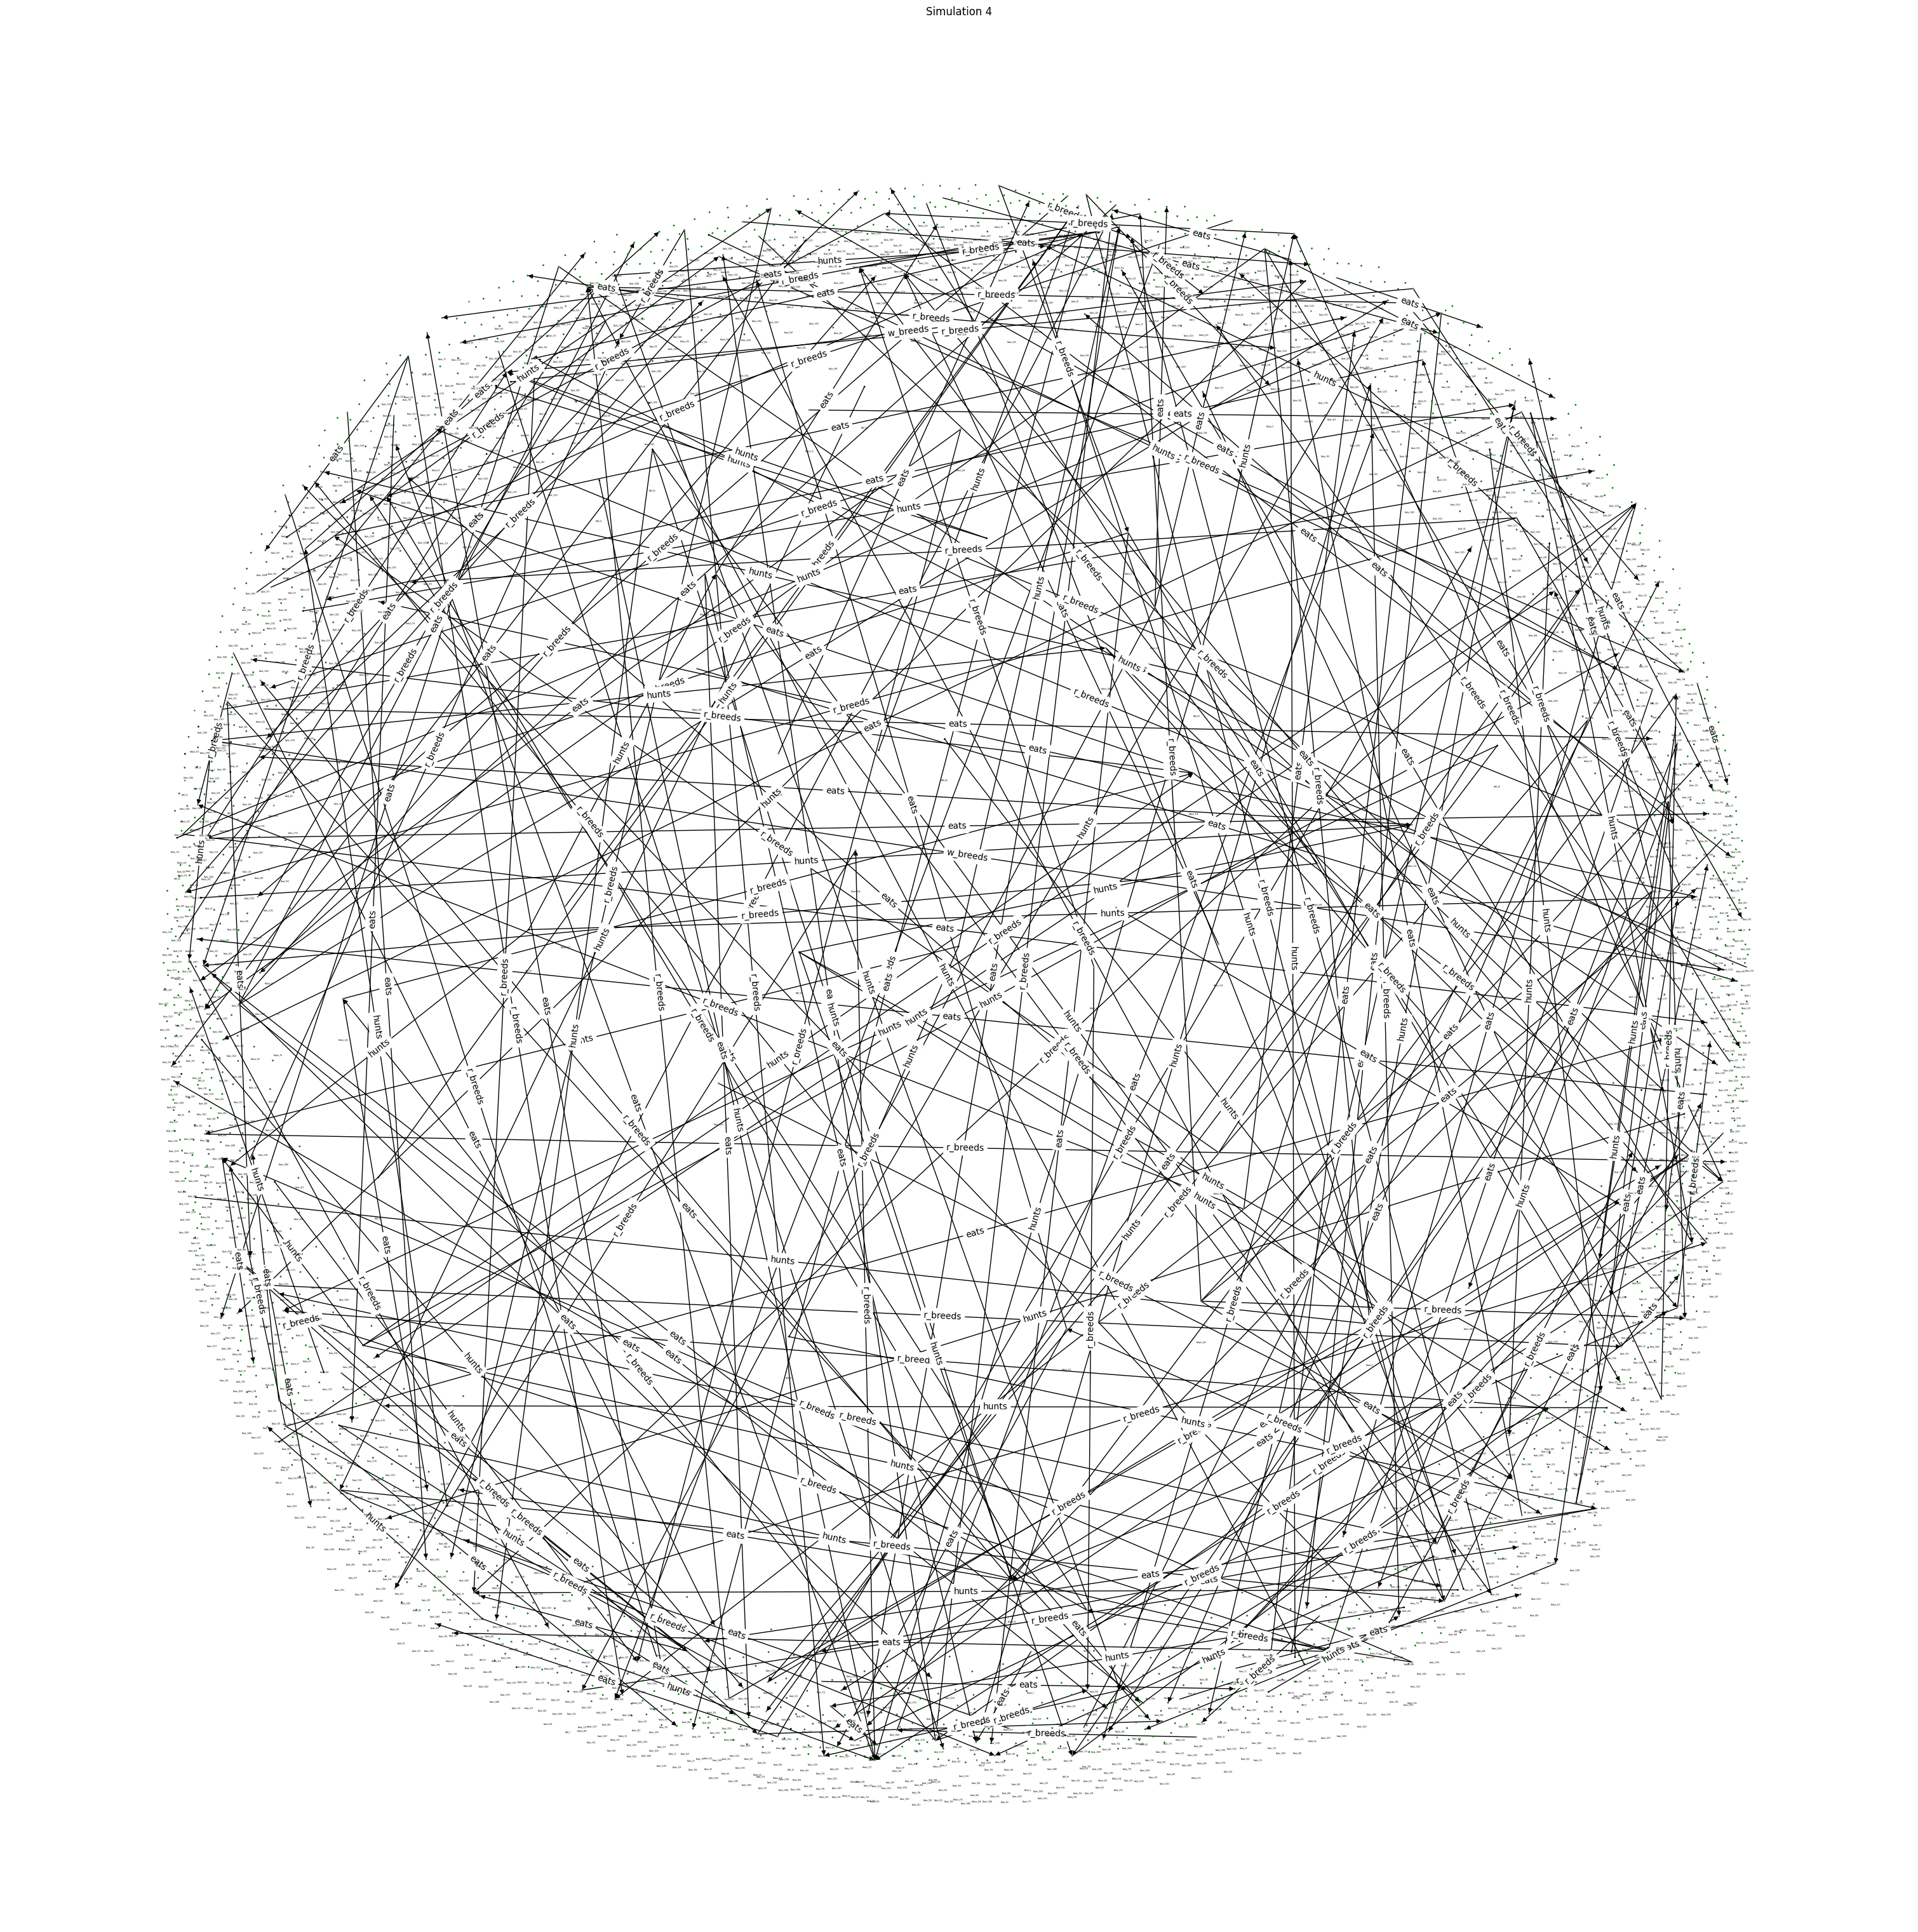

In [105]:
plot = G[0]
network_plot(plot, 4)